In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import legendre, hermite
from scipy.integrate import nquad, quad
from itertools import product

In [2]:
def function(Z1, Z2):
    """
    Calculate the value of the given function.

    Args:
        Z1 (float): First input parameter.
        Z2 (float): Second input parameter.

    Returns:
        float: The value of the mathematical function.
    """
    # adapted such that no coordinate transformation is necessary
    return -(Z1) * (Z2)**3 + np.exp(-0.5*(Z1)**2 - 0.1 * (Z2)**2)

def get_pairs(max_order, dims=2):
    """
    Generate pairs of integers where sum of each pair is less than or equal to max_order.

    Args:
        max_order (int): The maximum integer value for pairs.
        dims (int, optional): Number of dimensions for the pairs. Default is 2.

    Returns:
        list: List of pairs of integers.
    """
    pairs = []
    for pair in product(np.arange(0, max_order), repeat=dims):
        if sum(pair) <= max_order:
            pairs.append(pair)
    return pairs

def normal_pdf(x, mu=0, sigma=1):
    """
    Calculate the probability density function (PDF) of a normal (Gaussian) distribution.

    Args:
        x (float or ndarray): The value(s) at which to evaluate the PDF.
        mu (float, optional): The mean (average) of the normal distribution. Default is 0.
        sigma (float, optional): The standard deviation of the normal distribution. Default is 1.

    Returns:
        float or ndarray: The PDF value(s) at the specified input value(s).
    """
    return 1 / (sigma * np.sqrt(2*np.pi)) * np.exp(-0.5 * ((x - mu) / sigma)**2)



def integral_nominator(Z1, Z2, pair):
    """
    Calculate the integrand for a specific pair of Legendre and Hermite polynomials.

    Args:
        Z1 (float): First input parameter.
        Z2 (float): Second input parameter.
        pair (tuple): A pair of integers representing the orders of Legendre and Hermite polynomials.

    Returns:
        float: The value of the integrand.
    """
    f = function(Z1, Z2) # calculate f with transformed variables
    phi1 = legendre(pair[0])  # This line uses legendre, make sure it is imported or defined.
    phi2 = hermite(pair[1])  # This line uses hermite, make sure it is imported or defined.

    return f * phi1(Z1) * phi2(Z2) * 0.5 * normal_pdf(Z2)

def inner_leg(z, order):
    """
    Calculate the inner product of a Legendre polynomial of a given order.

    Args:
        z (float): The input value at which to evaluate the Legendre polynomial.
        order (int): The order of the Legendre polynomial.

    Returns:
        float: The inner product value.
    """
    phi = legendre(order)
    return phi(z) * phi(z) * 0.5

def inner_her(z, order):
    """
    Calculate the inner product of a Hermite polynomial of a given order.

    Args:
        z (float): The input value at which to evaluate the Hermite polynomial.
        order (int): The order of the Hermite polynomial.

    Returns:
        float: The inner product value.
    """
    phi = hermite(order) 
    return phi(z) * phi(z) * normal_pdf(z)

def get_coefficents(max_order, dims=2):
    """
    Calculate pairs of Legendre and Hermite polynomials and their coefficients.

    Args:
        max_order (int): The maximum order for Legendre and Hermite polynomials.
        dims (int, optional): Number of dimensions. Default is 2.

    Returns:
        tuple: A tuple containing pairs of Legendre and Hermite polynomials, and their coefficients.
    """
    pairs = get_pairs(max_order, dims)

    # Pre-calculate gamma's so we can reuse them
    gamma1s = []
    gamma2s = []
    for i in range(max_order+1):
            gamma1s.append(quad(inner_leg, -1, 1, args=i)[0])
            gamma2s.append(quad(inner_her, -np.inf, np.inf, args=i)[0])

    fhats = []
    for i, pair in enumerate(pairs):
        nominator = nquad(integral_nominator, [[-1, 1], [-np.inf, np.inf]], args=[pair])[0]
        fhats.append(nominator / (gamma1s[pair[0]] * gamma2s[pair[1]]))

    return pairs, fhats

def proj_eval(z1, z2, pairs, fhats):
    """
    Evaluate the projection of the function onto a set of basis functions.

    Args:
        z1 (array-like): Input values for the first dimension.
        z2 (array-like): Input values for the second dimension.
        pairs (list): List of pairs representing Legendre and Hermite polynomial orders.
        fhats (list): List of coefficients for each pair.

    Returns:
        ndarray: The projection matrix.
    """
    proj = np.zeros((len(z1), len(z1)))
    for i, pair in enumerate(pairs):
        proj += fhats[i] * legendre(pair[0])(z1) * hermite(pair[1])(z2)  # This line uses legendre and hermite, make sure they are imported or defined.

    return proj


In [3]:
X, Y = np.meshgrid(np.linspace(-1,1), np.linspace(-1,1))
Zf = function(X,Y)

In [4]:
np.mean(Zf)

0.8219493418086545

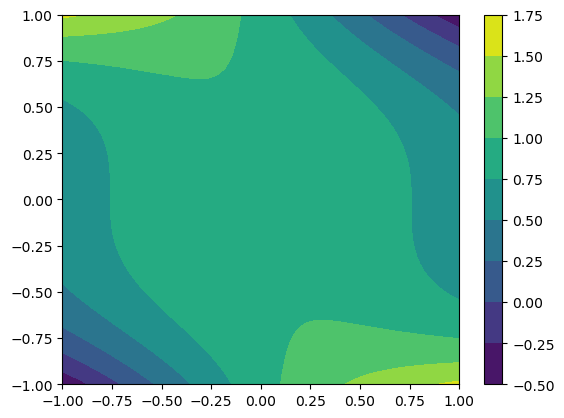

In [5]:
plt.contourf(X,Y,Zf)
plt.colorbar()

In [36]:
pairs, fhats = get_coefficents(20)
Zp = proj_eval(X,Y,pairs,fhats)

/Users/nik/opt/miniconda3/envs/IntroCLS/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1151: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,
/Users/nik/opt/miniconda3/envs/IntroCLS/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1151: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,
/Users/nik/opt/miniconda3/envs/IntroCLS/lib/python3.10/site-packages/scipy/integrate/_quadpack_py.py:1151: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinu

In [37]:
np.mean(Zp)

0.7584890262396875

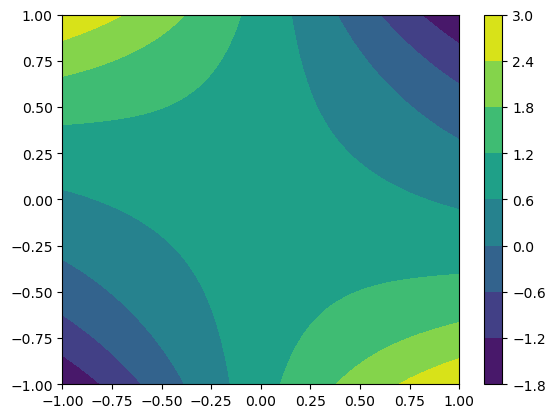

In [38]:
plt.contourf(X,Y,Zp)
plt.colorbar()

In [39]:
pZ = 1/len(X) * np.ones(len(X))
pZ = np.multiply(normal_pdf(Y), pZ)
sqrd_err = (Zp-Zf)**2
wE = np.sqrt(sqrd_err) * pZ
np.sum(wE)

6.164153915573091

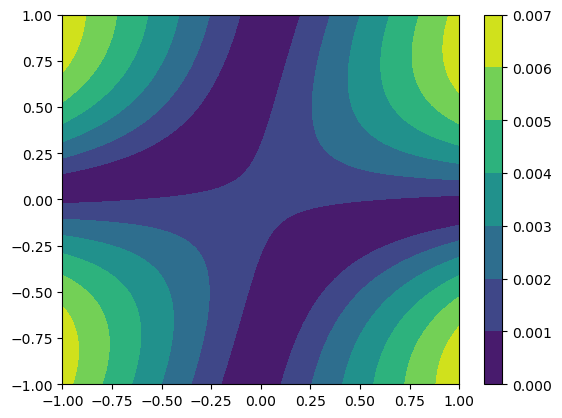

In [41]:
plt.contourf(X,Y,wE)
plt.colorbar()

In [42]:
np.sum(wE)

6.164153915573091

In [49]:
orders = [0,1,5,10,15,20]
errors = []

for order in orders:
    ord_pairs = get_pairs(order)
    ord_fhats = []
    for i,pair in enumerate(pairs):
        if pair in ord_pairs:
            ord_fhats.append(fhats[i])
    
    Zp = Zp = proj_eval(X,Y,ord_pairs,ord_fhats)
    sqrd_err = (Zp-Zf)**2
    wE = np.sqrt(sqrd_err) * pZ
    errors.append(np.sum(wE))

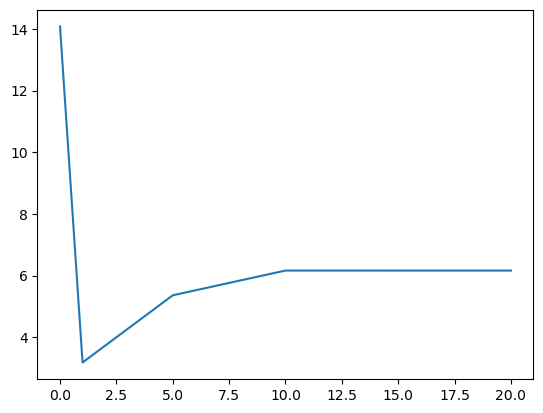

In [50]:
plt.plot(orders, errors)